<div style="text-align: center;">
    <h1>Géolocalisation des entreprises de la base Sirene</h1>
</div>



Pour l'instant, les entreprises sont localisées par leur codeCommuneInsee, on les situe donc soit au milieu de la commune soit sur un point aléatoire dans la commune. On va tenter d'affiner cette localisation.

- En enlevant les entreprises situées outre mer

- En assignant à chaque entreprise une position (lat,lon) la plus fiable possible


Pour cela on va utiliser le dataset [*Géolocalisation des établissements du répertoire SIRENE-pour les études statistiques*](https://www.data.gouv.fr/fr/datasets/geolocalisation-des-etablissements-du-repertoire-sirene-pour-les-etudes-statistiques/#/resources) proposé par l'INSEE. Il propose une localisation (lat,lon) pour chaque entreprise avec différents niveaux de confiance. La documentation relative à ce jeu de données est disponible [ici](https://www.data.gouv.fr/fr/datasets/r/9f6c2157-3c89-4e8d-8473-9894348c84cb).



**L'objectif de ce notebook est d'ajouter une localisation à chaque établissement** du fichier d'entreprises que l'on a constitué ('./data/Données nationales/RNE_Sirene.parquet).


On prend le parti pris suivant pour la suite : **Une entreprise sera décomptée si au moins une partie de la commune dans laquelle elle se situe est dans la zone de chalandise**.
La localisation de l'entreprise telle qu'on la considère ici n'est donc *pas un moyen de filtrer les entreprises* mais plutôt de donner des informations supplémentaires.

Ces informations seront ajoutées au fichier de base qui contiendra donc les variable suivantes :

- siret
- nomCommercial 
- adresse
- codeInseeCommune
- codeApe
- diffusionCommerciale

ET

- x_longitude
- y_latitude
- qualite_xy : un indicateur de la fiabilité de la localisation 



In [56]:
import pandas as pd
import folium
import numpy as np
import geopandas as gpd
import random
from shapely.geometry import Point, Polygon
from tqdm.notebook import tqdm
import shapely
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

# 1. Téléchargement et lecture du fichier

In [57]:
%%time

# paramètres
url = "https://www.data.gouv.fr/fr/datasets/r/ba6a4e4c-aac6-4764-bbd2-f80ae345afc5"
id_doc = url.split("/")[-1]
usecols = ["siret", "qualite_xy", "x_longitude", "y_latitude"]
dtypes = {
    "siret": np.int64,
    "qualite_xy": np.int8,
    "x_longitude": np.float64,
    "y_latitude": np.float64,
}


df = pd.read_csv(url, compression="zip", sep=";", usecols=usecols, dtype=dtypes)

CPU times: user 44.6 s, sys: 4.65 s, total: 49.3 s
Wall time: 2min 34s


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34513137 entries, 0 to 34513136
Data columns (total 4 columns):
 #   Column       Dtype  
---  ------       -----  
 0   siret        int64  
 1   qualite_xy   int8   
 2   y_latitude   float64
 3   x_longitude  float64
dtypes: float64(2), int64(1), int8(1)
memory usage: 822.9 MB


# 2. Jointure avec le fichier Registre

In [59]:
# paramètres
path = "../data/Données nationales/RNE_Sirene.parquet"
cols = [
    "siret",
    "nomCommercial",
    "adresse",
    "codeInseeCommune",
    "codeApe",
    "diffusionCommerciale",
]
dtypes = {
    "siret": np.int64,
    "nomCommercial": str,
    "adresse": str,
    "codeInseeCommune": str,
    "diffusionCommerciale": bool,
    "codeApe": str,
}

df_reg = pd.read_parquet("../data/Données nationales/RNE_Sirene.parquet")


# change dtype
df_reg = df_reg.astype(dtypes)

Quelques infos avant de faire la jointure

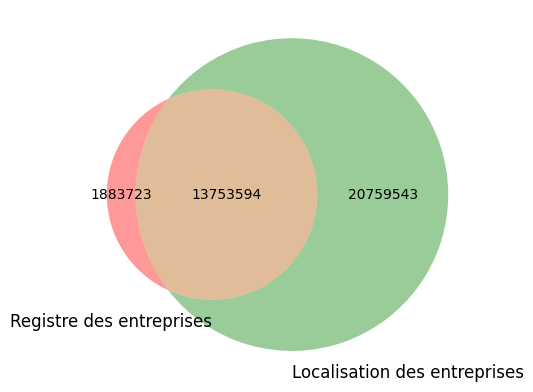

In [60]:
set_1 = set(df_reg.siret)
set_2 = set(df.siret)

venn2([set_1, set_2], ("Registre des entreprises", "Localisation des entreprises"))

plt.show()

Pourquoi est ce qu'il y a si peu d'entreprises localisées ?

- La base Sirene que nous avions téléchargé faisait 37 768 658 lignes , mais seulement 15 millions d'établissements actifs

Maintenant que l'on sait ça, on peut joindre les deux bases de données

In [61]:
df_reg_localise = pd.merge(df, df_reg, how="right", on="siret").reset_index(drop=True)

On alège la mémoire en enlevant les dataframes inutilisées

In [62]:
del df
del df_reg

Où sont situées les entreprises ?

<Axes: xlabel='x_longitude', ylabel='y_latitude'>

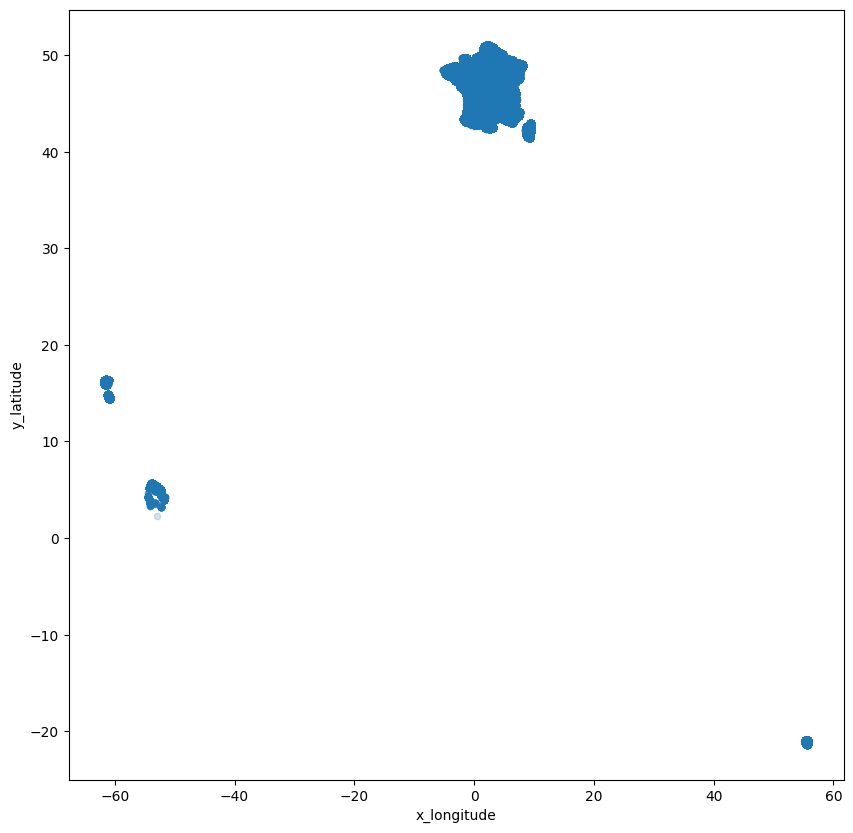

In [63]:
df_reg_localise.plot(
    kind="scatter", x="x_longitude", y="y_latitude", alpha=0.1, figsize=(10, 10)
)

# 3. Suppression des entreprises hors de France métropolitaine


On pourrait partir de la liste des codes communes des communes des outre-mer fournie par l'INSEE  dans le cadre du [Code Officiel Géographique (COG) 2023](https://www.insee.fr/fr/information/6800675).

Mais le plus simple est de filtrer avec une règle simple : **on enlève les établissements situés sous la 40 ème latitude.


<Axes: xlabel='x_longitude', ylabel='y_latitude'>

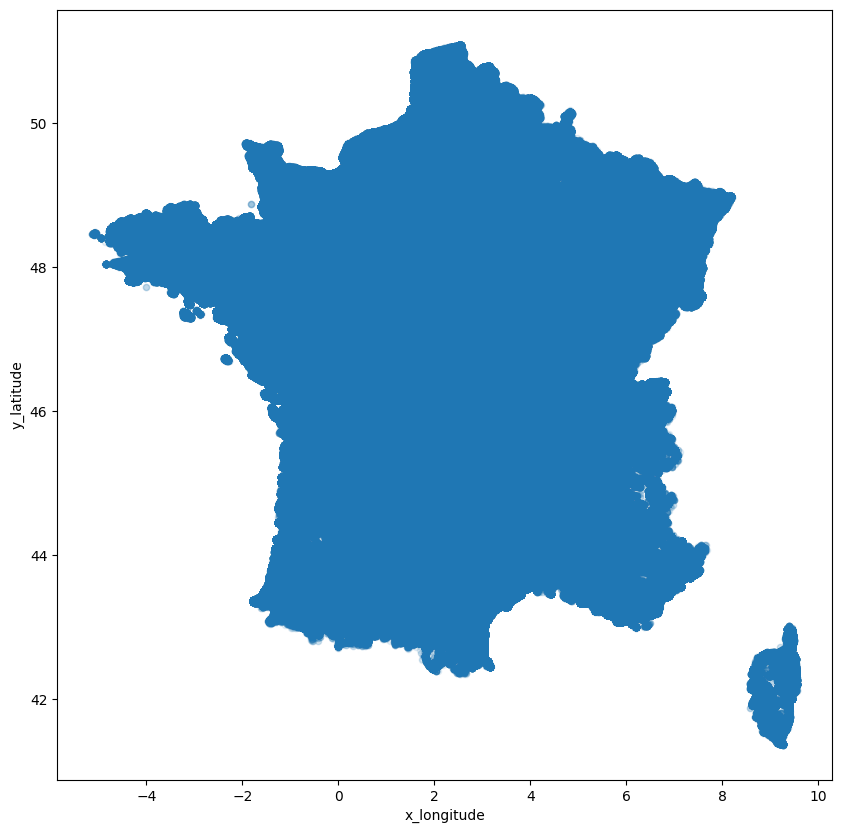

In [64]:
df_reg_localise[df_reg_localise.y_latitude > 40].plot(
    kind="scatter", x="x_longitude", y="y_latitude", alpha=0.1, figsize=(10, 10)
)

In [65]:
# on ne garde que les communes qui ne sont pas dans les DOM-TOM (pas dans la liste list)

df_reg_localise = df_reg_localise[df_reg_localise.y_latitude > 40].reset_index(
    drop=True
)

# 4. Complétion des données de localisation manquantes

Comme dit lors de l'introduction, on a envie de pouvoir signaler à l'utilisateur final que l'adresse n'est pas sure.

On va donc donner un indice de confiance plus lisible avec la correspondance suivantes (**voir documentation officielle INSEE**):

| Code | Type de Voie      | Détails                                    | Score |
|------|-------------------|--------------------------------------------|-------|
| 11    | Voie Sûre         | Numéro trouvé                               | 5     |
| 12   | Voie Sûre         | Position aléatoire dans la voie             | 4     |
| 21   | Voie probable     | Numéro trouvé                               | 3     |
| 22   | Voie probable     | Position aléatoire dans la voie             | 2     |
| 33   | Voie inconnue      | Position aléatoire dans la commune          | 1     |
| NaN  | Inconnu            | Position non renseignée dans le document de l'INSEE, localisation aléatoire dans la commune | 0   |



In [75]:
# change confiance
def give_confidence_score(x):
    correspondance = {11: 5, 12: 4, 21: 3, 22: 2, 33: 1, 0: 0}

    return correspondance[x]


df_reg_localise.fillna(0, inplace=True)
df_reg_localise["confiance"] = df_reg_localise.qualite_xy.apply(give_confidence_score)


Pour les établissments qui correspondent au dernier cas de figure (position non renseignée dans le document de l'INSEE on attribue une position aléatoire dans la commune).

Pour cela on va s'aider du document 'populationLocalisationCommunes.parquet' constitué dans [ce notebook](../Notebooks/5.%20Localisation%20des%20communes.ipynb).



<Axes: >

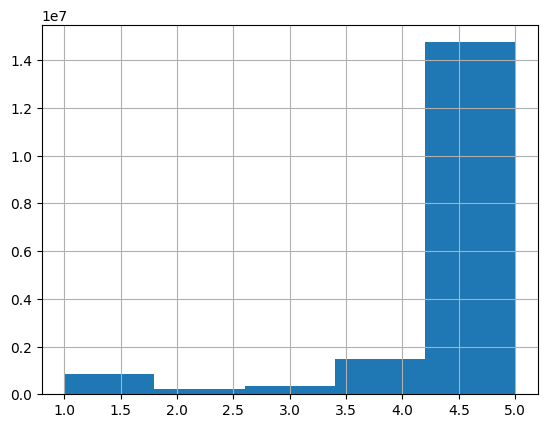

In [67]:
# comment se répartissent les entreprises par confiance ?
# affichage d'un histogramme

df_reg_localise.confiance.hist(bins=5)

Finalement , ca ne semble pas être nécessaire ! on garde tout de même notre fonction, sait on jamais.

On crée une fonction qui donne une position aléatoire dans une commune

In [68]:
def random_point_in_geometry(poly):
    if isinstance(poly, Polygon) or isinstance(poly, shapely.geometry.MultiPolygon):
        minx, miny, maxx, maxy = poly.bounds
        while True:
            p = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
            if poly.contains(p):
                return (p.x, p.y)

    else:
        return None


df_loc = gpd.read_parquet(
    "../data/Données nationales/populationLocalisationCommunes.parquet"
)[["codeCommune", "geometryCommune"]]


# test de la fonction
geom_paris = df_loc[df_loc.codeCommune == "75101"].geometry.values[0]

x, y = random_point_in_geometry(geom_paris)

# affichage d'une carte folium
m = folium.Map(location=[48.856578, 2.351828], zoom_start=12)
folium.GeoJson(geom_paris).add_to(m)

folium.Marker([y, x]).add_to(m)

m

# 5. Formattage final du fichier

On formatte le fichier pour qu'il puisse être directement utilisé pour la carte. 
On lui ajoutes les colonnes suivantes :

- 'nom' : le nom de l'entrepise, à défaut son siret
- 'adresse' : l'adresse de l'entreprise, à défaut le code postal de la ville

1. Le nom

In [85]:
df_reg_localise["nomCommercial"] = df_reg_localise.nomCommercial.replace(
    "None", "Non renseigné, voir Pappers"
)

2. L'adresse : On utilise un jeu de données de correspondance OpenDataSoft ([ici](https://public.opendatasoft.com/explore/dataset/correspondance-code-insee-code-postal/table/)).

(pas utile ici)

In [87]:
url = "https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/correspondance-code-insee-code-postal/exports/csv?lang=fr&timezone=Europe%2FBerlin&use_labels=true&delimiter=%3B"
usecols = ["Code INSEE", "Code Postal", "Commune"]
dtypes = {"Code INSEE": str, "Code Postal": str, "Commune": str}


df_corresp = pd.read_csv(url, sep=";", usecols=usecols, dtype=dtypes)

In [92]:
df_reg_localise.adresse.value_counts()

adresse
10 RUE DE PENTHIEVRE 75008 PARIS 8            7358
26 RUE DES RIGOLES 75020 PARIS 20             6424
128 RUE LA BOETIE 75008 PARIS 8               6362
66 AV DES CHAMPS ELYSEES 75008 PARIS 8        6355
60 RUE FRANCOIS 1ER 75008 PARIS 8             4525
                                              ... 
4300 DE BAGNOLS EN FORET 83920 LA MOTTE          1
1 RUE VOLTAIRE 59225 MONTIGNY-EN-CAMBRESIS       1
14 AV FRANCOIS DUPONT 57970 YUTZ                 1
2 SQ DE L HOTEL DE VILLE 22430 ERQUY             1
288 BD DE METZ 54350 MONT-SAINT-MARTIN           1
Name: count, Length: 6871655, dtype: int64

In [89]:
temp = df_reg_localise[df_reg_localise.adresse == "0"]

temp["index"] = temp.index

temp = pd.merge(
    temp, df_corresp, how="left", left_on="codeInseeCommune", right_on="Code INSEE"
)

temp["adresse"] = temp["Code Postal"] + " " + temp["Commune"]

In [93]:
df_reg_localise.to_parquet("../data/Données nationales/RNE_Sirene_localisé.parquet")